<a href="https://colab.research.google.com/github/hopedom/DS5/blob/main/day7_%EC%8B%9C%EA%B0%84%EA%B4%80%EB%A0%A8_%ED%94%BC%EC%B3%90%EC%97%94%EC%A7%80%EB%8B%88%EC%96%B4%EB%A7%81_%EC%A3%BC%EC%A0%9C1_%EC%A0%84%EB%9E%B5A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

주제 1 : ‘시간’을 활용한 피쳐 엔지니어링
___
"우리는 주어진 데이터를 그대로 사용할 것인가, 아니면 한계를 극복하기 위해 변형할 것인가?”

**주 목표**  
- 기본 모델의 성능은 알고리즘이 아니라 피쳐의 품질에 의해 제한되는 경우가 많습니다.
- 이 팀의 미션은, 회귀 모델이 이해할 수 있는 방식으로 시간 기반 데이터, 특히 주기적 데이터를 표현하는 방법을 조사하는 것입니다.
- 주기적 데이터의 특성을 잘 반영하도록 변환하였을 때, 모델 성능에는 어떤 변화가 있나요?

# **전략 A: 시간 단계를 범주로 취급**  
___
- **개념:** 각 시간(0, 1,..., 23)을 별개의 범주로 취급합니다. 모델이 각 시간에 고유한 계수를 할당할 수 있는 자유를 통해 선형성을 제거할 수 있습니다.
- **분석:** `OneHotEncoder`가 어떻게 작동하는지, 이 접근법의 장점(유연성)과 단점(높은 차원, 과적합 가능성)에 대해 설명하세요.

In [ ]:
from sklearn.datasets import fetch_openml
import pandas as pd

bike_sharing = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True)
df = bike_sharing.frame

In [ ]:
def prep_dataset_by_case(df, case=1):
  if case == 1:
    X = df.drop(["count", "season", "holiday", "workingday", "weather"], axis="columns")
    y = df["count"] / df["count"].max()
    return X, y

  elif case == 2:
    X = df.drop(["count", "season", "holiday", "workingday", "weather"], axis="columns")
    X = pd.get_dummies(X, columns = ['hour'])
    y = df["count"] / df["count"].max()
    return X, y

In [ ]:
X1, y1  = prep_dataset_by_case(df, 1)
X1.shape, y1.shape
display(X1.head(3))

,year,month,hour,weekday,temp,feel_temp,humidity,windspeed
0,0,1,0,6,9.84,14.395,0.81,0.0
1,0,1,1,6,9.02,13.635,0.80,0.0
2,0,1,2,6,9.02,13.635,0.80,0.0


In [ ]:
X2, y2  = prep_dataset_by_case(df, 2)
X2.shape, y2.shape
display(X2.head(3))

,year,month,weekday,temp,feel_temp,humidity,windspeed,hour_0,hour_1,hour_2,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0,1,6,9.84,14.395,0.81,0.0,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,1,6,9.02,13.635,0.80,0.0,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,0,1,6,9.02,13.635,0.80,0.0,False,False,True,...,False,False,False,False,False,False,False,False,False,False


**TimeSeriesSplit**  
- KFold의 variation으로 데이터의 time-order를 보존하며 분할 (데이터가 이미 시간 순서대로 정렬되어 있다고 가정)
- 학습 데이터셋은 항상 검증 데이터셋보다 시간적으로 앞선 시점의 데이터로만 구성됨  
- 주요 파라미터
  - **n_splits**: split 수 (기본값: 5)
  - **gap**: 각 학습 데이터셋의 끝 부분과 검증 데이터셋의 시작 부분 사이에 데이터의 수 (기본값: 0)
  - **max_train_size** ; training set의 max. size (기본값: 0)
  - **test_size** : testing set size (기본값: n_samples // n_splits + 1)
- KFold 와의 차이점
  - KFold는 데이터를 무작위로 섞은 후, 지정된 `split`만큼 분할. 각 폴드를 한번씩 검증 데이터로 활용  
  - TimeSeriesSplits은 무작위로 섞지 않고, index를 기준으로 지정된 `split+1`만큼 분할


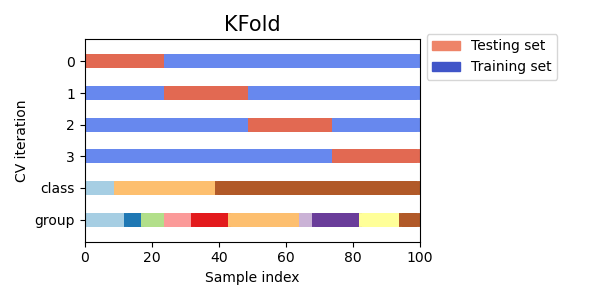
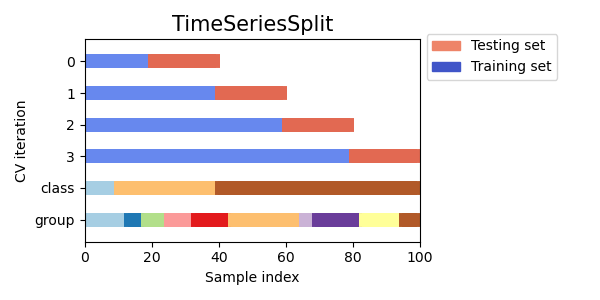

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=10000,
    test_size=1000,
)

In [ ]:
all_splits = list(ts_cv.split(X1, y1))
train_0, test_0 = all_splits[0]

X1.iloc[train_0]

,year,month,hour,weekday,temp,feel_temp,humidity,windspeed
2331,0,4,1,2,25.42,31.060,0.50,6.0032
2332,0,4,2,2,24.60,31.060,0.53,8.9981
2333,0,4,3,2,23.78,27.275,0.56,8.9981
2334,0,4,4,2,22.96,26.515,0.64,8.9981
2335,0,4,5,2,22.14,25.760,0.68,8.9981
...,...,...,...,...,...,...,...,...
12326,1,6,19,6,26.24,31.060,0.36,11.0014
12327,1,6,20,6,25.42,31.060,0.35,19.0012
12328,1,6,21,6,24.60,31.060,0.40,7.0015
12329,1,6,22,6,23.78,27.275,0.46,8.9981


In [ ]:
X1.iloc[test_0].head(3)

,year,month,hour,weekday,temp,feel_temp,humidity,windspeed
12379,1,6,0,2,22.14,25.76,0.68,27.9993
12380,1,6,1,2,21.32,25.00,0.77,22.0028
12381,1,6,2,2,21.32,25.00,0.72,19.9995


## Case1: No One-Hot Encoding

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
import numpy as np

def evaluate(model, X, y, cv, model_prop=None, model_step=None):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
        return_estimator=model_prop is not None,
    )
    if model_prop is not None:
        if model_step is not None:
            values = [
                getattr(m[model_step], model_prop) for m in cv_results["estimator"]
            ]
        else:
            values = [getattr(m, model_prop) for m in cv_results["estimator"]]
        print(f"Mean model.{model_prop} = {np.mean(values)}")
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )
    return rmse

Gradient Boosting

In [ ]:
gbrt = HistGradientBoostingRegressor(random_state=42)
result_case1_gbrt = evaluate(gbrt, X1, y1, cv=ts_cv, model_prop="n_iter_")

Mean model.n_iter_ = 100.0
Mean Absolute Error:     0.050 +/- 0.005
Root Mean Squared Error: 0.076 +/- 0.010


Naive linear regression

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

naive_linear_pipeline = make_pipeline(
    MinMaxScaler(),
    RidgeCV(alphas=np.logspace(-6, 6, 25))
    )

result_case1_ridge = evaluate(naive_linear_pipeline, X1, y1, cv=ts_cv, model_prop="alpha_", model_step="ridgecv")

Mean model.alpha_ = 3.4849110640673517
Mean Absolute Error:     0.146 +/- 0.015
Root Mean Squared Error: 0.186 +/- 0.018


## Case2: One-Hot Encoding

Gradient Boosting

In [ ]:
result_case2_gbrt = evaluate(gbrt, X2, y2, cv=ts_cv, model_prop="n_iter_")

Mean model.n_iter_ = 100.0
Mean Absolute Error:     0.062 +/- 0.009
Root Mean Squared Error: 0.087 +/- 0.012


Naive linear regression

In [ ]:
result_case2_ridge = evaluate(naive_linear_pipeline, X2, y2, cv=ts_cv, model_prop="alpha_", model_step="ridgecv")

Mean model.alpha_ = 0.6832455532033677
Mean Absolute Error:     0.102 +/- 0.009
Root Mean Squared Error: 0.135 +/- 0.009


## 결과 비교

### 예측 성능(RMSE)

In [ ]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def plot_rmse_comparison_with_cv(model, X_c1, y_c1, X_c2, y_c2):
    ts_cv = TimeSeriesSplit(n_splits=5, gap=48, max_train_size=10000, test_size=1000)

    def get_cv_performance(X, y):
        train_rmses = []
        val_rmses = []

        for train_index, val_index in ts_cv.split(X):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            model.fit(X_train, y_train)

            train_rmse = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
            val_rmse = np.sqrt(mean_squared_error(y_val, model.predict(X_val)))

            train_rmses.append(train_rmse)
            val_rmses.append(val_rmse)

        return np.mean(train_rmses), np.mean(val_rmses)

    avg_train_rmse_c1, avg_val_rmse_c1 = get_cv_performance(X_c1, y_c1)
    avg_train_rmse_c2, avg_val_rmse_c2 = get_cv_performance(X_c2, y_c2)

    labels = ['Case 1 (No One-Hot)', 'Case 2 (One-Hot)']
    train_rmses = [avg_train_rmse_c1, avg_train_rmse_c2]
    val_rmses = [avg_val_rmse_c1, avg_val_rmse_c2]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.bar(x - width/2, train_rmses, width, label='Training')
    ax.bar(x + width/2, val_rmses, width, label='Validation', color='coral')

    ax.set_ylabel('RMSE')
    ax.set_title(f'RMSE Comparison ({model.__class__.__name__})')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    for i in range(len(labels)):
        ax.text(x[i] - width/2, train_rmses[i], f'{train_rmses[i]:.4f}', ha='center', va='bottom')
        ax.text(x[i] + width/2, val_rmses[i], f'{val_rmses[i]:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

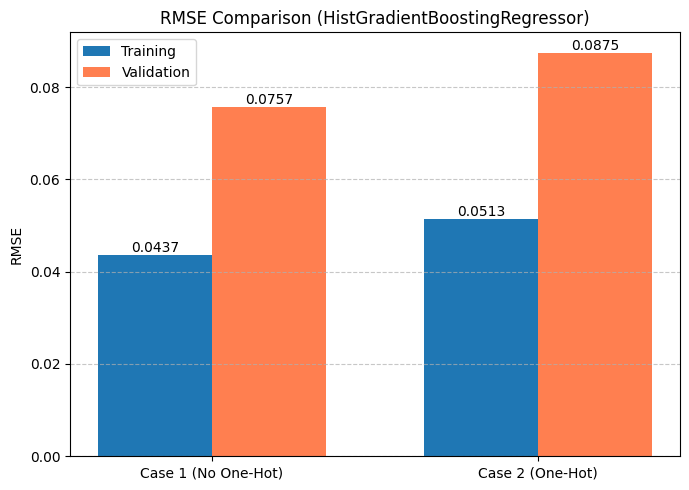

In [ ]:
plot_rmse_comparison_with_cv(gbrt, X1, y1, X2, y2)

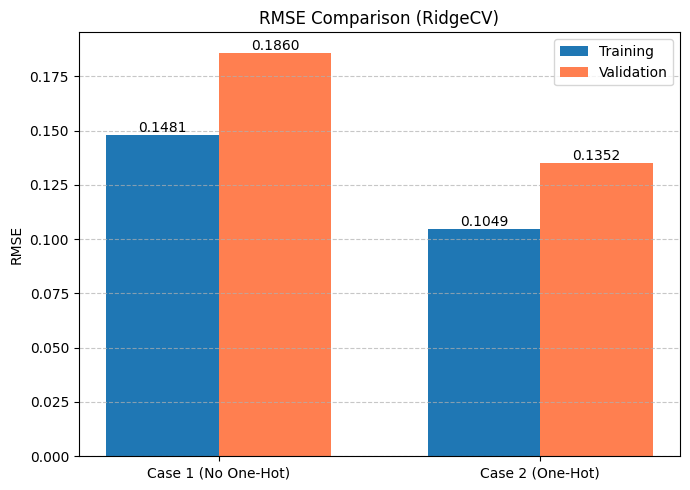

In [ ]:
plot_rmse_comparison_with_cv(RidgeCV(alphas=np.logspace(-6, 6, 25)), X1, y1, X2, y2)

In [ ]:
res = {
    'mean': [result_case1_gbrt.mean(), result_case2_gbrt.mean(), result_case1_ridge.mean(), result_case2_ridge.mean()],
    'std': [result_case1_gbrt.std(), result_case2_gbrt.std(), result_case1_ridge.std(), result_case2_ridge.std()],
}
res = pd.DataFrame(res, index = ['C1_GBRT', 'C2_GBRT', 'C1_RIDGE', 'C2_RIDGE']).T
display(res)

,C1_GBRT,C2_GBRT,C1_RIDGE,C2_RIDGE
mean,0.075748,0.087473,0.186075,0.135130
std,0.009959,0.011526,0.017673,0.008734


[결과 분석]  
- 인코딩 적용 시, Ridge 모델은 각 시간대별로 독립적인 영향을 모델 학습을 할 수 있게 되어 예측 성능이 향상됨  
- 하지만 Gradient Boosting 모델은 예측 성능이 떨어졌음  
- 이 결과는 특징 수의 증가로 인해 모델의 차원이 높아졌고, **과적합(overfitting)** 이 발생할 가능성이 높아졌다고 해석할 수 있음
  

### Permutation Importance

In [ ]:
from sklearn.inspection import permutation_importance

def get_permutation_importance(model, X, y):
  model.fit(X, y)

  result = permutation_importance(model, X, y, n_repeats=10, random_state=42)

  sorted_idx = result.importances_mean.argsort()
  sorted_features = X.columns[sorted_idx]

  return pd.Series(result.importances_mean[sorted_idx], index = sorted_features)

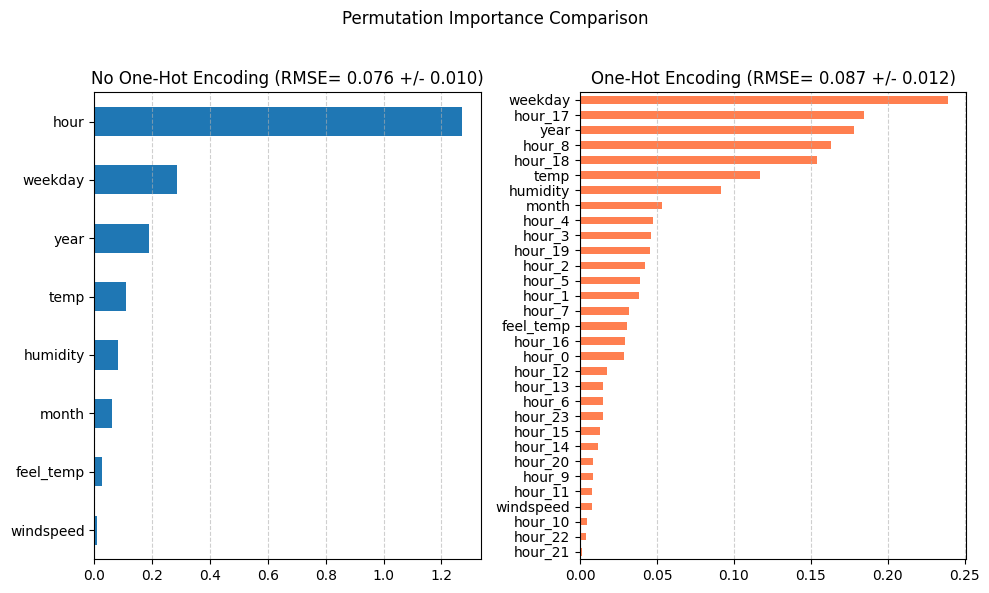

In [ ]:
pi_c1 = get_permutation_importance(HistGradientBoostingRegressor(random_state=42), X1, y1)
pi_c2 = get_permutation_importance(HistGradientBoostingRegressor(random_state=42), X2, y2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle("Permutation Importance Comparison", fontsize=12)

pi_c1.plot.barh(ax=ax1)
ax1.set_title(f"No One-Hot Encoding (RMSE= {res['C1_GBRT']['mean']:.3f} +/- {res['C1_GBRT']['std']:.3f})")
ax1.grid(axis='x', linestyle='--', alpha=0.6)

pi_c2.plot.barh(ax=ax2, color='coral')
ax2.set_title(f"One-Hot Encoding (RMSE= {res['C2_GBRT']['mean']:.3f} +/- {res['C2_GBRT']['std']:.3f})")
ax2.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
print('--- hour 특징의 permutation importance 비교 ---')
print(f'Case 1 (단일) : {pi_c1['hour']:.2f}')
print(f'Case 2 (총합) : {pi_c2[pi_c2.index.str.startswith('hour')].sum():.2f}')

--- hour 특징의 permutation importance 비교 ---
Case 1 (단일) : 1.27
Case 2 (총합) : 0.97


- Case1에서는 `hour`가 가장 높은 importance를 나타냈음
- Case2에서도 `hour` 관련 feature의 permutation importance를 합하면 여전히 가장 높은 importance를 가지고 있음

### Coefficient

In [ ]:
def get_ridge_coefficients(X, y, alphas = np.logspace(-6, 6, 25)):
    naive_linear_pipeline = make_pipeline(
        MinMaxScaler(),
        RidgeCV(alphas=alphas)
    )
    naive_linear_pipeline.fit(X, y)
    ridge_model = naive_linear_pipeline.named_steps['ridgecv']
    return pd.Series(ridge_model.coef_, index=X.columns).sort_values(key=abs)

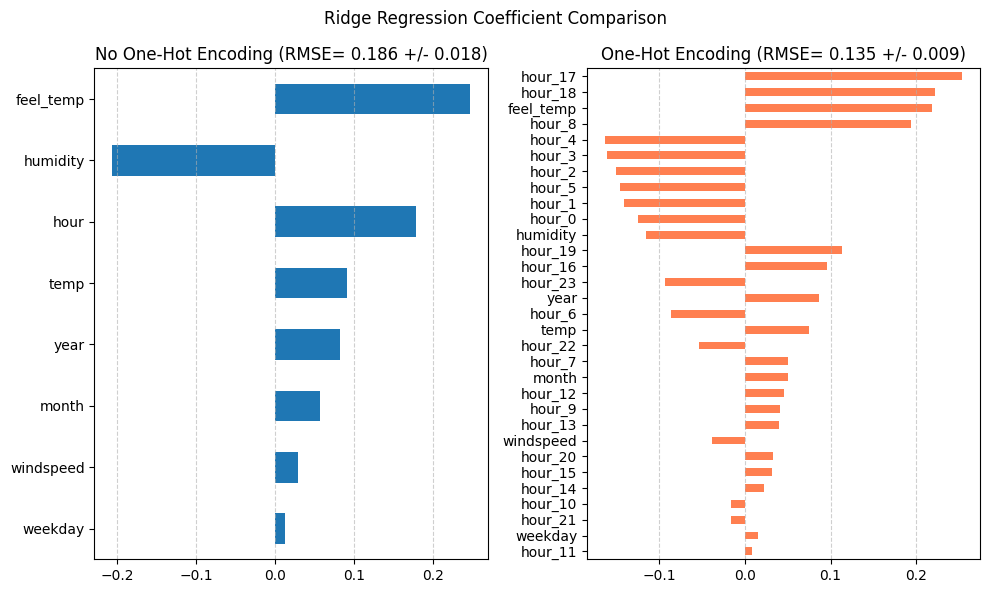

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle("Ridge Regression Coefficient Comparison", fontsize=12)

ridge_coeffs_c1 = get_ridge_coefficients(X1, y1)
ridge_coeffs_c1.plot.barh(ax=ax1)
ax1.set_title(f"No One-Hot Encoding (RMSE= {res['C1_RIDGE']['mean']:.3f} +/- {res['C1_RIDGE']['std']:.3f})")
ax1.grid(axis='x', linestyle='--', alpha=0.6)

ridge_coeffs_c2 = get_ridge_coefficients(X2, y2)
ridge_coeffs_c2.plot.barh(ax=ax2, color='coral')
ax2.set_title(f"One-Hot Encoding (RMSE= {res['C2_RIDGE']['mean']:.3f} +/- {res['C2_RIDGE']['std']:.3f})")
ax2.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

Ridge Regression 모델의 Coefficient 비교
- Case 1의 경우, hour의 계수가 양수인 것으로 추축컨데, 늦은 시간대에 대여량이 컸을 가능성이 있음
- Case 2의 경우, 출근시간(7 ~ 9), 퇴근시간(16 ~ 19)에는 계수가 양수이며, 취침시간(0 ~ 6)에는 계수가 음수인 것을 확인할 수 있음